## COMP5625M Assessment 2 - Image Caption Generation [100 marks]

<div class="logos"><img src="https://drive.google.com/uc?id=132BXgkV5w1bpXlVpdr5BtZdpagqYvna7" width="220px" align="right"></div>

The maximum marks for each part are shown in the section headers. The overall assessment carries a total of 100 marks.

This assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this assessment, you will:

> 1. Understand the principles of text pre-processing and vocabulary building.
> 2. Gain experience working with an image-to-text model.
> 3. Use and compare two text similarity metrics for evaluating an image-to-text model, and understand evaluation challenges.


### Setup and resources 

Having a GPU will speed up the image feature extraction process. If you want to use a GPU, please refer to the module website for recommended working environments with GPUs.

Please implement the coursework using PyTorch and Python-based libraries, and refer to the notebooks and exercises provided.

This assessment will use a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) for image caption generation. COCO contains 330K images of 80 object categories, and at least five textual reference captions per image. Our subset consists of nearly 5070 of these images, each with five or more different descriptions of the salient entities and activities, and we will refer to it as COCO_5070.

To download the data:

> 1. **Images and annotations**: download the zipped file provided in the link here as [``COMP5625M_data_assessment_2.zip``](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/EWWzE-_AIrlOkvOKxH4rjIgBF_eUx8KDJMPKM2eHwCE0dg?e=DdX62H). 

``Info only:`` To understand more about the COCO dataset, you can look at the [download page](https://cocodataset.org/#download). We have already provided you with the "2017 Train/Val annotations (241MB)", but our image subset consists of fewer images than the original COCO dataset. **So, no need to download anything from here!** 

> 2. **Image metadata**: as our set is a subset of the full COCO dataset, we have created a CSV file containing relevant metadata for our particular subset of images. You can also download it from Drive, "coco_subset_meta.csv", at the same link as 1.


### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, in .ipynb format. **Do not change the file name.**
> 2. The .html version of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) are displayed in the .html for marking.

**Final note:**

> **Please include everything you would like to be marked in this notebook, including figures. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the appropriate section.** Feel free to add as many code cells as you need under each section.

Your student username (for example, ```sc15jb```):

sc22qh

Your full name:

QiuYuan Han

### Imports

Feel free to add to this section as needed.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms
from torchvision.io import read_image
import torchvision.models as models
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.hub import load_state_dict_from_url
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np
from PIL import Image

Detect which device (CPU/GPU) to use.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [3]:
from google.colab import drive
drive.mount('/content/drive')
# mounted on MyDrive
!ls '/content/drive/'

Mounted at /content/drive
MyDrive


The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last convolutional layer of a pre-trained CNN (we use [ResNet50](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects. 

**(Hint)** You can alternatively use the COCO trained pretrained weights from [PyTorch](https://pytorch.org/vision/stable/models.html). One way to do this is use the "FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1" but use e.g., "resnet_model = model.backbone.body". Alternatively, you can use the checkpoint from your previous coursework where you finetuned to COCO dataset. 

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by *a batch normalisation layer* to speed up training. Those resulting features, as well as the reference text captions, are then passed into a recurrent network (we will use **RNN** in this assessment). 

The reference captions used to compute loss are represented as numerical vectors via an **embedding layer** whose weights are learned during training.

<!-- ![Encoder Decoder](comp5625M_figure.jpg) --> 


<div>
<center><img src="https://drive.google.com/uc?id=1GMJSVZpym0bqzqe9YwEYXpzIdtCyTgLk" width="1000"/></center>
</div>


The Encoder-Decoder network could be coupled and trained end-to-end, without saving features to disk; however, this requires iterating through the entire image training set during training. We can make the **training more efficient by decoupling the networks**. Thus, we will:

> First extract the feature representations of the images from the Encoder

> Save these features (Part 1) such that during the training of the Decoder (Part 3), we only need to iterate over the image feature data and the reference captions.

**Hint**
Try commenting out the feature extraction part once you have saved the embeddings. This way if you have to re-run the entire codes for some reason then you can only load these features. 


### Overview

> 1. Extracting image features 
> 2. Text preparation of training and validation data 
> 3. Training the decoder
> 4. Generating predictions on test data
> 5. Caption evaluation via BLEU score
> 6. Caption evaluation via Cosine similarity
> 7. Comparing BLEU and Cosine similarity


## 1 Extracting image features [11 marks]

> 1.1 Design a encoder layer with pretrained ResNet50 (4 marks)

> 1.2 Image feature extraction step (7 marks)

#### 1.1 Design a encoder layer with pretrained ResNet50 (4 marks)

> Read through the template EncoderCNN class below and complete the class.

> You are expected to use ResNet50 pretrained on imageNet provided in the Pytorch library (torchvision.models)


In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-50 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        # Your code here!
        Pretrained_Net=models.resnet50(models.ResNet50_Weights.IMAGENET1K_V2)
        self.layers=nn.Sequential(*(list(Pretrained_Net.children())[:-1]))
        # TO COMPLETE
        # keep all layers of the pretrained net except the last layers of fully-connected ones (you are permitted to take other layers too but this can affect your accuracy!)

        
    def forward(self, images):
        """Extract feature vectors from input images."""
        return self.layers(images)
        # TO COMPLETE
        # remember no gradients are needed
        # return features 


In [ ]:
# instantiate encoder and put into evaluation mode.
# Your code here!
encoder=EncoderCNN()
encoder.eval()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 91.5MB/s]


EncoderCNN(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

#### 1.2 Image feature extraction step (7 marks)

Pass the images through the ```Encoder``` model, saving the resulting features for each image. You may like to use a ```Dataset``` and ```DataLoader``` to load the data in batches for faster processing, or you may choose to simply read in one image at a time from disk without any loaders.

Note that as this is a forward pass only, no gradients are needed. You will need to be able to match each image ID (the image name without file extension) with its features later, so we suggest either saving a dictionary of image ID: image features, or keeping a separate ordered list of image IDs.

Use this ImageNet transform provided.

In [ ]:
data_transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Resize(224), 
    transforms.CenterCrop(224), 
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

In [ ]:
# Get unique images from the csv for extracting features - helper code
imageList = pd.read_csv("/content/drive/MyDrive/DeepLearing/COMP5625M_data_assessment_2/coco_subset_meta.csv")
imageList['file_name']
len(imageList.id.unique())

imagesUnique = sorted(imageList['file_name'].unique())
print(len(imagesUnique))

df_unique_files =  pd.DataFrame.from_dict(imagesUnique)

df_unique_files.columns = ['file_name']
df_unique_files

5068


file_name
0     000000000009.jpg
1     000000000025.jpg
2     000000000030.jpg
3     000000000034.jpg
4     000000000036.jpg
...                ...
5063  000000581906.jpg
5064  000000581909.jpg
5065  000000581913.jpg
5066  000000581921.jpg
5067  000000581929.jpg

[5068 rows x 1 columns]

In [ ]:
df_unique_files.iloc[4:10]

file_name
4  000000000036.jpg
5  000000000042.jpg
6  000000000049.jpg
7  000000000061.jpg
8  000000000064.jpg
9  000000000071.jpg

In [ ]:
# Define a class COCOImagesDataset(Dataset) function that takes the 
# image file names and reads the image and apply transform to it
# ---> your code here! we have provided you a sketch 

IMAGE_DIR = "/content/drive/MyDrive/DeepLearing/COMP5625M_data_assessment_2/coco/images/"

class COCOImagesDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        # --> your code here!
        self.transform=transform

    def __getitem__(self, index):
        filename = self.df.iloc[index]['file_name']
        file_path=IMAGE_DIR+filename
        # --> your code here!
        image = Image.open(file_path).convert("RGB")
        # image=read_image(filename)
        if self.transform:
          image=self.transform(image)
        return image, filename

    def __len__(self):
        return len(self.df)
    

In [ ]:
# Use Dataloader to use the unique files using the class COCOImagesDataset
# make sure that shuffle is False as we are not aiming to retrain in this exercise
# Your code here-->
dataset=COCOImagesDataset(df_unique_files,data_transform)
dataloader = DataLoader(dataset)
image, filename=next(iter(dataloader))
print(filename)


('000000000009.jpg',)


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


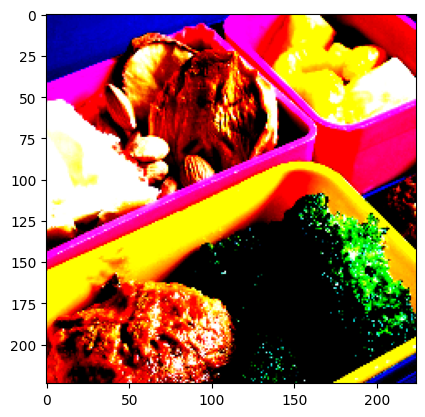

In [ ]:
img=image.reshape(3,224,224)
img_show=np.transpose(img.numpy(),(1,2,0))
plt.imshow(img_show)

In [ ]:
# Apply encoder to extract featues and save them (e.g., you can save it using image_ids)
# Hint - make sure to save your features after running this - you can use torch.save to do this

features_map = dict()
from tqdm.notebook import tqdm
from PIL import Image

with torch.no_grad():
# ---> Your code here!
  for data in dataloader:
    image, filename=data
    out_feature=encoder(image)
    features_map[filename]=out_feature
torch.save(features_map,'/content/drive/MyDrive/DeepLearing/cw2/encoder_feature.pt')




/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [4]:
# Load the file
features_map = torch.load("/content/drive/MyDrive/DeepLearing/cw2/encoder_feature.pt")

In [ ]:
# pt_file

## 2 Text preparation [23 marks]

> 2.1 Build the caption dataset (3 Marks)

> 2.2 Clean the captions (3 marks)

> 2.3 Split the data (3 marks)

> 2.4 Building the vocabulary (10 marks)

> 2.5 Prepare dataset using dataloader (4 marks)


#### 2.1 Build the caption dataset (3 Marks)

All our selected COCO_5029 images are from the official 2017 train set.

The ```coco_subset_meta.csv``` file includes the image filenames and unique IDs of all the images in our subset. The ```id``` column corresponds to each unique image ID.

The COCO dataset includes many different types of annotations: bounding boxes, keypoints, reference captions, and more. We are interested in the captioning labels. Open ```captions_train2017.json``` from the zip file downloaded from the COCO website. You are welcome to come up with your own way of doing it, but we recommend using the ```json``` package to initially inspect the data, then the ```pandas``` package to look at the annotations (if you read in the file as ```data```, then you can access the annotations dictionary as ```data['annotations']```).

Use ```coco_subset_meta.csv``` to cross-reference with the annotations from ```captions_train2017.json``` to get all the reference captions for each image in COCO_5029.

For example, you may end up with data looking like this (this is a ```pandas``` DataFrame, but it could also be several lists, or some other data structure/s):

<img src="caption_image_ids.png" alt="images matched to caption" width="700"/>

In [ ]:
import json

# loading captions for training
with open('/content/drive/MyDrive/DeepLearing/COMP5625M_data_assessment_2/coco/annotations2017/captions_train2017.json', 'r') as json_file:
    data = json.load(json_file)
    
df = pd.DataFrame.from_dict(data["annotations"])
df.head()

image_id   id                                            caption
0    203564   37  A bicycle replica with a clock as the front wh...
1    322141   49  A room with blue walls and a white sink and door.
2     16977   89  A car that seems to be parked illegally behind...
3    106140   98  A large passenger airplane flying through the ...
4    106140  101  There is a GOL plane taking off in a partly cl...

In [ ]:
df

image_id      id                                            caption
0         203564      37  A bicycle replica with a clock as the front wh...
1         322141      49  A room with blue walls and a white sink and door.
2          16977      89  A car that seems to be parked illegally behind...
3         106140      98  A large passenger airplane flying through the ...
4         106140     101  There is a GOL plane taking off in a partly cl...
...          ...     ...                                                ...
591748    133071  829655  a slice of bread is covered with a sour cream ...
591749    410182  829658  A long plate hold some fries with some sliders...
591750    180285  829665       Two women sit and pose with stuffed animals.
591751    133071  829693  White Plate with a lot of guacamole and an ext...
591752    133071  829717      A dinner plate has a lemon wedge garnishment.

[591753 rows x 3 columns]

In [ ]:
# Hint: get the filename matching id from coco_subset_meta.csv - make sure that for each id you add image filename
coco_subset = pd.read_csv("/content/drive/MyDrive/DeepLearing/COMP5625M_data_assessment_2/coco_subset_meta.csv")
# --> your code here! - name the new dataframe as "new_file"
new_file=pd.merge(df,coco_subset[['file_name','id']],how='left',left_on='image_id',right_on='id')
new_file=new_file.drop_duplicates(subset=['file_name']).dropna()
new_file

image_id    id_x                                            caption  \
69         57429    2049  An airplane with its landing wheels out landing.    
101       410627    2961  The young man is stirring his pot of food with...   
169       554037    5010  a counter with vegetables, knife and cutting b...   
198       143370    5786  A bathroom with a poster of an ugly face above...   
267       540860    7732      A green car on display next to a busy street.   
...          ...     ...                                                ...   
605710    360589  803024  a clear decorative vase is filled with colorfu...   
605826    426350  806384  Burger sitting on a white plate with fries and...   
605863    327717  807673          A shrine with many vases in front of it.    
605919    206998  809956         some store items hanging on a display wall   
606393    180285  829395       A couple of women with some stuffed animals.   

               file_name      id_y  
69      000000057429.jpg   57429.0  
101     000000410627.jpg  410627.0  
169     000000554037.jpg  554037.0  
198     000000143370.jpg  143370.0  
267     000000540860.jpg  540860.0  
...                  ...       ...  
605710  000000360589.jpg  360589.0  
605826  000000426350.jpg  426350.0  
605863  000000327717.jpg  327717.0  
605919  000000206998.jpg  206998.0  
606393  000000180285.jpg  180285.0  

[5068 rows x 5 columns]

In [ ]:
coco_subset.isna().values.any()

False

In [ ]:
# coco_subset['id']
coco_subset

Unnamed: 0  license         file_name  \
0              0        2  000000262145.jpg   
1              1        1  000000262146.jpg   
2              2        3  000000524291.jpg   
3              3        1  000000262148.jpg   
4              4        3  000000393223.jpg   
...          ...      ...               ...   
7995        7995        1  000000059582.jpg   
7996        7996        3  000000514241.jpg   
7997        7997        3  000000069826.jpg   
7998        7998        1  000000108739.jpg   
7999        7999        1  000000080067.jpg   

                                               coco_url  height  width  \
0     http://images.cocodataset.org/train2017/000000...     427    640   
1     http://images.cocodataset.org/train2017/000000...     640    480   
2     http://images.cocodataset.org/train2017/000000...     426    640   
3     http://images.cocodataset.org/train2017/000000...     512    640   
4     http://images.cocodataset.org/train2017/000000...     480    640   
...                                                 ...     ...    ...   
7995  http://images.cocodataset.org/train2017/000000...     480    640   
7996  http://images.cocodataset.org/train2017/000000...     640    606   
7997  http://images.cocodataset.org/train2017/000000...     640    485   
7998  http://images.cocodataset.org/train2017/000000...     480    640   
7999  http://images.cocodataset.org/train2017/000000...     640    480   

            date_captured                                         flickr_url  \
0     2013-11-20 02:07:55  http://farm8.staticflickr.com/7187/6967031859_...   
1     2013-11-19 23:07:16  http://farm6.staticflickr.com/5090/5341741494_...   
2     2013-11-18 09:59:07  http://farm2.staticflickr.com/1045/934293170_d...   
3     2013-11-20 05:50:03  http://farm5.staticflickr.com/4028/4549977479_...   
4     2013-11-21 20:08:57  http://farm1.staticflickr.com/28/45521803_c5cb...   
...                   ...                                                ...   
7995  2013-11-21 19:55:42  http://farm3.staticflickr.com/2555/3949313138_...   
7996  2013-11-21 19:31:28  http://farm5.staticflickr.com/4011/4213856619_...   
7997  2013-11-15 03:04:38  http://farm1.staticflickr.com/26/62186181_2ca3...   
7998  2013-11-21 19:17:46  http://farm9.staticflickr.com/8143/7670833864_...   
7999  2013-11-18 15:57:46  http://farm7.staticflickr.com/6231/6305552632_...   

          id  
0     262145  
1     262146  
2     524291  
3     262148  
4     393223  
...      ...  
7995   59582  
7996  514241  
7997   69826  
7998  108739  
7999   80067  

[8000 rows x 9 columns]

#### 2.2 Clean the captions (3 marks)

Create a cleaned version of each caption. If using dataframes, we suggest saving the cleaned captions in a new column; otherwise, if you are storing your data in some other way, create data structures as needed. 

**A cleaned caption should be all lowercase, and consist of only alphabet characters.**

Print out 10 original captions next to their cleaned versions to facilitate marking.


<img src="cleancaptions.png" alt="images matched to caption" width="700"/>

In [ ]:
import re
new_file["clean_caption"] = "" # add a new column to the dataframe for the cleaned captions

def gen_clean_captions_df(df):

    # Remove spaces in the beginning and at the end
    # Convert to lower case
    # Replace all non-alphabet characters with space
    # Replace all continuous spaces with a single space

    # -->your code here
    clean_caption=new_file["caption"].map(lambda x:' '.join(x.strip().lower().split()))
    clean_caption=clean_caption.map(lambda x:re.sub("[\W]",' ',x.strip()))
    # add to dataframe
    df["clean_caption"] = clean_caption

    return df

In [ ]:
# clean and print 10 of these
new_file = gen_clean_captions_df(new_file)
new_file.head(10)

image_id   id_x                                            caption  \
69       57429   2049  An airplane with its landing wheels out landing.    
101     410627   2961  The young man is stirring his pot of food with...   
169     554037   5010  a counter with vegetables, knife and cutting b...   
198     143370   5786  A bathroom with a poster of an ugly face above...   
267     540860   7732      A green car on display next to a busy street.   
391      40986  11208  Raw cookies in a pan on the counter and baked ...   
749     445002  21595      an empty modern style bathroom for two people   
874      79920  24537  A living room with a large tv and pictures all...   
1027    442609  28505  A messy kitchen with pots and pans laying around.   
1151    139440  32240    Six people in a boat rowing on a body of water.   

             file_name      id_y  \
69    000000057429.jpg   57429.0   
101   000000410627.jpg  410627.0   
169   000000554037.jpg  554037.0   
198   000000143370.jpg  143370.0   
267   000000540860.jpg  540860.0   
391   000000040986.jpg   40986.0   
749   000000445002.jpg  445002.0   
874   000000079920.jpg   79920.0   
1027  000000442609.jpg  442609.0   
1151  000000139440.jpg  139440.0   

                                          clean_caption  
69     an airplane with its landing wheels out landing   
101   the young man is stirring his pot of food with...  
169   a counter with vegetables  knife and cutting b...  
198   a bathroom with a poster of an ugly face above...  
267       a green car on display next to a busy street   
391   raw cookies in a pan on the counter and baked ...  
749       an empty modern style bathroom for two people  
874   a living room with a large tv and pictures all...  
1027  a messy kitchen with pots and pans laying around   
1151    six people in a boat rowing on a body of water

In [ ]:
# save dataframe
torch.save(new_file,'/content/drive/MyDrive/DeepLearing/cw2/new_file.pt')



In [10]:
# Load new_file
new_file = torch.load("/content/drive/MyDrive/DeepLearing/cw2/new_file.pt")

#### 2.3  Split the data (3 marks)

Split the data 70/10/20% into train/validation/test sets. **Be sure that each unique image (and all corresponding captions) only appear in a single set.**

We provide the function below which, given a list of unique image IDs and a 3-split ratio, shuffles and returns  a split of the image IDs.

If using a dataframe, ```df['image_id'].unique()``` will return the list of unique image IDs.

In [ ]:
import random
import math

def split_ids(image_id_list, train=.7, valid=0.1, test=0.2):
    """
    Args:
        image_id_list (int list): list of unique image ids
        train (float): train split size (between 0 - 1)
        valid (float): valid split size (between 0 - 1)
        test (float): test split size (between 0 - 1)
    """
    list_copy = image_id_list.copy()
    random.shuffle(list_copy)
    
    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)
    
    return list_copy[:train_size], list_copy[train_size:(train_size + valid_size)], list_copy[(train_size + valid_size):]

In [ ]:
image_id_list=new_file['image_id'].unique()

In [ ]:
image_id_list.shape

(5068,)

In [ ]:
train_set,val_set,test_set=split_ids(image_id_list)

In [ ]:
print(len(train_set),len(val_set),len(test_set))

3547 506 1015


#### 2.4 Building the vocabulary (10 marks)

The vocabulary consists of all the possible words which can be used - both as input into the model, and as output predictions, and we will build it using the cleaned words found in the reference captions from the training set. In the vocabulary each unique word is mapped to a unique integer (a Python ```dictionary``` object).

A ```Vocabulary``` object is provided for you below to use.

In [5]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
      # if the word does not already exist in the dictionary, add it
      if not word in self.word2idx:
          # this will convert each word to index and index to word as you saw in the tutorials
          self.word2idx[word] = self.idx
          self.idx2word[self.idx] = word
          # increment the ID for the next word
          self.idx += 1
    def get_word(self, idx):
      return self.idx2word[idx]
      
    def __call__(self, word):
      # if we try to access a word not in the dictionary, return the id for <unk>
      if not word in self.word2idx:
          return self.word2idx['<unk>']
      return self.word2idx[word]

    def __len__(self):
      return len(self.word2idx)


Collect all words from the cleaned captions in the **training and validation sets**, ignoring any words which appear 3 times or less; this should leave you with roughly 2200 words (plus or minus is fine). As the vocabulary size affects the embedding layer dimensions, it is better not to add the very infrequently used words to the vocabulary.

Create an instance of the ```Vocabulary()``` object and add all your words to it.

In [6]:
# [Hint] building a vocab function such with frequent words e.g., setting MIN_FREQUENCY = 3
MIN_FREQUENCY = 3

def build_vocab(df_ids, new_file):
    """ 
    Parses training set token file captions and builds a Vocabulary object and dataframe for 
    the image and caption data

    Returns:
        vocab (Vocabulary): Vocabulary object containing all words appearing more than min_frequency
    """
    word_mapping = Counter()

    # for index in df.index:
    for index, id in enumerate(df_ids):
        caption = str(new_file.loc[new_file['image_id']==id]['clean_caption'].values[0])
        # print(caption)
        for word in caption.split():
            # also get rid of numbers, symbols etc.
            if word in word_mapping:
                word_mapping[word] += 1
            else:
                word_mapping[word] = 1

    # create a vocab instance
    vocab = Vocabulary()

    # add the words to the vocabulary
    for word in word_mapping:
        # Ignore infrequent words to reduce the embedding size
        # --> Your code here!
        if word_mapping[word]>MIN_FREQUENCY:
          vocab.add_word(word)

    return vocab


In [ ]:
full_vocab=build_vocab(image_id_list,new_file)

In [ ]:
full_vocab.__len__()

1028

In [ ]:
id=74
new_file.loc[new_file['image_id']==id]['clean_caption'].values[0]

'a picture of a dog laying on the ground '

In [ ]:
# build your vocabulary for train, valid and test sets
# ---> your code here!
train_vocab=build_vocab(train_set,new_file)
val_vocab=build_vocab(val_set,new_file)
test_vocab=build_vocab(test_set,new_file)

In [ ]:
train_vocab.__len__()

1460

In [ ]:
train_vocab.__len__()+val_vocab.__len__()+test_vocab.__len__()

2641

In [ ]:
# save dataframe|
torch.save(full_vocab,'/content/drive/MyDrive/DeepLearing/cw2/full_vocab.pt')
torch.save(train_vocab,'/content/drive/MyDrive/DeepLearing/cw2/train_vocab.pt')
torch.save(val_vocab,'/content/drive/MyDrive/DeepLearing/cw2/val_vocab.pt')
torch.save(test_vocab,'/content/drive/MyDrive/DeepLearing/cw2/test_vocab.pt')

In [7]:
# Load vocab
full_vocab = torch.load('/content/drive/MyDrive/DeepLearing/cw2/full_vocab.pt')
train_vocab = torch.load("/content/drive/MyDrive/DeepLearing/cw2/train_vocab.pt")
val_vocab = torch.load("/content/drive/MyDrive/DeepLearing/cw2/val_vocab.pt")
test_vocab = torch.load("/content/drive/MyDrive/DeepLearing/cw2/test_vocab.pt")

#### 2.5 Prepare dataset using dataloader (4 marks)

Create a PyTorch ```Dataset``` class and a corresponding ```DataLoader``` for the inputs to the decoder. Create three sets: one each for training, validation, and test. Set ```shuffle=True``` for the training set DataLoader.

The ```Dataset``` function ```__getitem__(self, index)``` should return three Tensors:

>1. A Tensor of image features, dimension (1, 2048).
>2. A Tensor of integer word ids representing the reference caption; use your ```Vocabulary``` object to convert each word in the caption to a word ID. Be sure to add the word ID for the ```<end>``` token at the end of each caption, then fill in the the rest of the caption with the ```<pad>``` token so that each caption has uniform lenth (max sequence length) of **47**.
>3. A Tensor of integers representing the true lengths of every caption in the batch (include the ```<end>``` token in the count).


Note that as each unique image has five or more (say, ```n```) reference captions, each image feature will appear ```n``` times, once in each unique (feature, caption) pair.

In [8]:
MAX_SEQ_LEN = 47

class COCO_Features(Dataset):
    """ COCO subset custom dataset, compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, df, features, vocab):
        """
        Args:
            df: (dataframe or some other data structure/s you may prefer to use)
            features: image features
            vocab: vocabulary wrapper
           
        """
        # TO COMPLETE
        self.df=df
        self.features=features
        self.vocab=vocab

    
    def __getitem__(self, index):

        """ Returns one data tuple (feature [1, 2048], target caption of word IDs [1, 47], and integer true caption length) """   
        # TO COMPLETE
        image_name=self.df.iloc[index]["file_name"]
        # change dim
        # features=self.features[(image_name,)].squeeze()
        features=self.features[(image_name,)].squeeze(dim=[2,3])
        caption=self.df.iloc[index]['clean_caption']
        target_captions=[]
        for word in caption.split():
          target_captions.append(self.vocab.__call__(word))
        target_captions.append(self.vocab.__call__('<end>'))
        true_caption_len=len(target_captions)
        for i in range(MAX_SEQ_LEN-true_caption_len):
          target_captions.append(self.vocab.__call__('<pad>'))
        target_captions=torch.Tensor(target_captions)
        # add 1 dim
        # target_captions=target_captions.unsqueeze(dim=0)
        return (features,target_captions,true_caption_len,image_name)
    
    
    def __len__(self):
        return len(self.features)
    

In [ ]:
new_file.iloc[1]["file_name"],new_file.iloc[1]['clean_caption']


('000000410627.jpg',
 'the young man is stirring his pot of food with a wooden spoon ')

In [ ]:
caption=new_file.iloc[1]['clean_caption']
idx=[]
for word in caption.split():
  print(word,full_vocab.__call__(word))
  idx.append(full_vocab.__call__(word))
idx_to_word(idx)

the 10
young 11
man 12
is 13
stirring 1
his 14
pot 15
of 16
food 17
with 5
a 18
wooden 19
spoon 20


'the young man is <unk> his pot of food with a wooden spoon '

In [ ]:
# def caption_collate_fn(data):
#     """ Creates mini-batch tensors from the list of tuples (image, caption).
#     Args:
#         data: list of tuple (image, caption). 
#             - image: torch tensor of shape (3, 224, 224).
#             - caption: torch tensor of shape (?); variable length.
#     Returns:
#         images: torch tensor of shape (batch_size, 3, 224, 224).
#         targets: torch tensor of shape (batch_size, padded_length).
#         lengths: list; valid length for each padded caption.
#     """
#     # --> Your code here
#     # Sort a data list by caption length from longest to shortest.
#     sort_data=sorted(data,key=lambda x :len(x[1]),reverse=True)
#     padded_size=len(sort_data[0][1])


#     # merge images (from tuple of 3D tensor to 4D tensor).
#     # if using features, 2D tensor to 3D tensor. (batch_size, 256)
#     images=torch.cat(torch.stack([cell[0] for cell in sort_data]))



#     # merge captions (from tuple of 1D tensor to 2D tensor).
#     # pad with zeros
#     targets=torch.cat(torch.stack([F.pas(input=cell[1],pad=(0,padded_size-len(cell[1])),mode='constant', value=0) for cell in sort_data]))
#     lengths=[len(cell[1]) for cell in sort_data]


#     return images, targets, lengths


In [ ]:
# Test pad
# data = torch.ones(4)
# new_data = F.pad(input=data, pad=(0,1), mode='constant', value=0)
# new_data

# Test sort
data=[('a','1'),('b','12'),('c','123')]
sort_data=sorted(data,key=lambda x :len(x[1]),reverse=True)
sort_data
lengths=[len(cell[1]) for cell in sort_data]
lengths

[3, 2, 1]

In [11]:
#  your dataloader here (make shuffle true as you will be training RNN)
# --> your code here!
dataset_full = COCO_Features(
    df=new_file,
    vocab=full_vocab,
    features=features_map,
)
dataset_train = COCO_Features(
    df=new_file,
    vocab=train_vocab,
    features=features_map,
)

# Do the same as above for your validation set
# ---> your code here!
dataset_val = COCO_Features(
    df=new_file,
    vocab=val_vocab,
    features=features_map,
)



dataset_test = COCO_Features(
    df=new_file,
    vocab=train_vocab,
    features=features_map,
)
full_loader = DataLoader(dataset_full,batch_size=64,shuffle=False)
# train_loader = DataLoader(dataset_train,batch_size=64,shuffle=True)
# val_loader = DataLoader(dataset_val,batch_size=64,shuffle=False)



Load one batch of the training set and print out the shape of each returned Tensor.

In [ ]:
# Test DataLoader
x,y,z,N=next(iter(full_loader))
# len(y)
# y.shape
# x.shape
print(x.shape,y.shape,z.shape)

torch.Size([64, 1, 2048]) torch.Size([64, 47]) torch.Size([64])


In [ ]:
idx_to_word(y[3])

'a bathroom with a <unk> of an <unk> face above the <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> '

In [ ]:
'''
Test 
'''
# # train_set
# df=new_file
features=features_map
# index=410627
# index=115077
# image_name=df.loc[df['image_id']==index]["file_name"].values[0]
# cap=df.loc[df['image_id']==index]['clean_caption'].values[0]
# # print(image_name.values[0],cap.values[0])
# features_0=features[(image_name,)]
# features_0

In [ ]:
# Test features
fea=features[('000000115077.jpg',)]
fea=fea.squeeze(dim=[2,3])
fea.shape
# features

torch.Size([1, 2048])

## 3 Train DecoderRNN [20 marks]

> 3.1 Design RNN-based decoder (10 marks)

> 3.2 Train your model with precomputed features (10 Marks)

#### 3.1 Design a RNN-based decoder (10 marks)

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```RNN``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).


In [12]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last convolutional layer (flattened to dimensions after AdaptiveAvgPool2d that may give you => 1 x 1 x 2048, other layers are also accepted but this will affect your accuracy!)
        # into a Linear layer to resize
        # your code
        self.flatten=nn.Flatten()
        self.resize=nn.Linear(1*2048,hidden_size)
        
        # batch normalisation helps to speed up training
        # your code
        self.bn=nn.BatchNorm1d(hidden_size)

        # your code for embedding layer
        self.embed=nn.Embedding(vocab_size,embed_size)
   

        # your code for RNN
        # self.rnn=nn.RNN(embed_size,hidden_size,num_layers,batch_first=True)
        self.rnn=nn.GRU(embed_size,hidden_size,num_layers,batch_first=True)

        # self.linear: linear layer with input: hidden layer, output: vocab size
        # --> your code
        self.linear=nn.Linear(hidden_size,vocab_size)

        self.rnn_layers=num_layers
        self.max_seq_length = max_seq_length
        

    def forward(self, features, captions, lengths, zero_hidden = True):
        """Decode image feature vectors and generates captions."""
        # sort lengths in descending order
        # lengths,perm_idx =lengths.sort(0,descending=True)
        # captions=captions[perm_idx]
        # features=features[perm_idx]
        
        # compute your feature embeddings
        # your code
        # vocabsize(1028)->embed_size(256)
        embeddings = self.embed(captions)
        # print("embeddings_shape:",embeddings.shape)
    
        # pack_padded_sequence returns a PackedSequence object, which contains two items: 
        # the packed data (data cut off at its true length and flattened into one list), and 
        # the batch_sizes, or the number of elements at each sequence step in the batch.
        # For instance, given data [a, b, c] and [x] the PackedSequence would contain data 
        # [a, x, b, c] with batch_sizes=[2,1,1].

        # your code [hint: use pack_padded_sequence]
        
        packed=nn.utils.rnn.pack_padded_sequence(embeddings,lengths,batch_first=True,enforce_sorted=False)
        # im_features=hidden_size=512
        # print("features:",features.shape)
        im_features = self.flatten(features)
        # print("features_flatten:",im_features.shape)
        im_features = self.resize(im_features)
        # print("features_resize:",im_features.shape)
        im_features = self.bn(im_features)
        im_features=im_features.unsqueeze(dim=0)
        # print("features_unsqueeze:",im_features.shape)
        # multilayer rnn hidden states
        im_features=im_features.repeat(self.rnn_layers,1,1)
        # print("features_multilayer:",im_features.shape)
        # Feed in to RNN
        if zero_hidden:
          self.hidden=im_features

          # packed_output, hidden=self.rnn(packed)
          
        packed_output, hidden=self.rnn(packed,self.hidden)
        # else:
        #   packed_output, hidden=self.rnn(packed,self.hidden)
        self.hidden=hidden
        # print("hidden_shape:",self.hidden.shape)
        # self.hidden=hidden.detach_()
        output,_ = pad_packed_sequence(packed_output, batch_first=True)
        # print("outputs shape",output.shape)
        outputs = self.linear(output) #hint: use a hidden layers in parenthesis
        return outputs
    
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))   # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)               # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)              # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)       # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids
    

In [13]:
# instantiate decoder
# your code here!
# vocab_size=train_vocab.__len__()+val_vocab.__len__()+test_vocab.__len__()
vocab_size=full_vocab.__len__()
decoder=DecoderRNN(vocab_size,num_layers=2)


In [ ]:
decoder.parameters

<bound method Module.parameters of DecoderRNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (resize): Linear(in_features=2048, out_features=512, bias=True)
  (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (embed): Embedding(1028, 256)
  (rnn): GRU(256, 512, num_layers=2, batch_first=True)
  (linear): Linear(in_features=512, out_features=1028, bias=True)
)>

In [ ]:
from torch import nn
input_dim = 10
embedding_dim = 2
embedding = nn.Embedding(input_dim, embedding_dim)
err = False
if err:
    #Any input more than input_dim - 1, here input_dim = 10
    #Any input less than zero
    input_to_embed = torch.tensor([10])
    print(input_to_embed.shape)
else:
    input_to_embed = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    print(input_to_embed.shape)
embed = embedding(input_to_embed)
print(embed)

torch.Size([10])
tensor([[ 1.7166, -0.6398],
        [ 0.2584, -0.9193],
        [-0.2769,  0.6407],
        [ 0.9744,  1.8947],
        [-0.7155, -0.0375],
        [-1.2285, -0.0253],
        [-1.1916, -0.3951],
        [ 0.7982,  2.1150],
        [ 0.3771, -0.5879],
        [ 0.5387,  0.7150]], grad_fn=<EmbeddingBackward0>)


In [ ]:
# features,captions,lengths=next(iter(train_loader))
# out=decoder(features,captions,lengths)
for features,captions,lengths,_ in full_loader:
  # print(features.shape,captions.shape,lengths.shape)
  inputs=captions[:,:-1]
  target=captions[:,1:]
  inputs=inputs.long()
  print(inputs.shape,target.shape)
  print(features.shape,captions.shape)
  out=decoder(features,inputs,lengths-1,zero_hidden=True)
  print(out.shape)
  break

torch.Size([64, 46]) torch.Size([64, 46])
torch.Size([64, 1, 2048]) torch.Size([64, 47])
torch.Size([64, 19, 1028])


In [ ]:
lengths

tensor([11, 10, 11, 15, 11, 14, 13,  9, 10, 10, 16, 14,  9, 11, 10, 17, 10, 10,
        11, 11, 11, 13, 13, 11,  9, 13, 11, 11, 11,  9, 11,  9,  9, 10,  9, 12,
        12, 10, 11, 11, 12,  9,  9, 12, 12,  9, 13, 13, 10, 19, 15, 13, 12,  9,
        11, 10, 11, 11,  9, 10, 11,  9, 13, 11])

In [ ]:
# a=captions[0]
num=1
a=target[num]
_,b=torch.max(out[num],dim=1)
a.shape,b.shape

(torch.Size([46]), torch.Size([19]))

In [ ]:
a,b

(tensor([11., 12., 13.,  1., 14., 15., 16., 17.,  5., 18., 19., 20.,  2.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.]),
 tensor([ 11,  12,  13,  13,  14, 243,  16,  17,   2,  18,  19,   2,   2,   1,
           1,   1,   1,   1,   1]))

In [ ]:
def show_caption(a):
  out=''
  for i in a:
    out+=full_vocab.get_word(int(i))
    out+=' '
  return out  

In [ ]:
show_caption(a)

'young man is <unk> his pot of food with a wooden spoon <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> '

In [ ]:
show_caption(b)

'young man is is his bowl of food <end> a wooden <end> <end> <unk> <unk> <unk> <unk> <unk> <unk> '

In [ ]:
test=out[0,1,]
sum(test),max(test)
test.sort()

torch.return_types.sort(
values=tensor([-0.6930, -0.6754, -0.6700,  ...,  0.7756,  0.8112,  0.8588],
       grad_fn=<SortBackward0>),
indices=tensor([460,  10, 770,  ...,  15, 273, 428]))

In [ ]:
m = nn.LogSoftmax(dim=1)
input = torch.randn(3, 5, requires_grad=True)
# input.shape,m(input).shape
input

tensor([[ 1.0834, -1.2499, -1.7308,  0.8085, -0.3939],
        [-1.9638,  0.5763,  1.2482,  0.0755, -0.9307],
        [ 1.3065, -1.0104, -2.5680,  0.2199, -0.1034]], requires_grad=True)

In [ ]:
captions[0].shape
out[0].shape

torch.Size([47, 1746])

In [ ]:
max_test=torch.amax(out, dim=(2))
max_test[0]

tensor([ 1.0748,  0.7224,  0.9540,  0.7936,  0.8142,  0.8067,  0.7159,  0.7652,
         0.6204,  7.6854,  9.8966, 10.6000, 10.6914, 10.7267, 10.7335, 10.7337,
        10.7347, 10.7347, 10.7348, 10.7347, 10.7347, 10.7347, 10.7347, 10.7347,
        10.7347, 10.7347, 10.7347, 10.7347, 10.7347, 10.7347, 10.7347, 10.7347,
        10.7347, 10.7347, 10.7347, 10.7347, 10.7347, 10.7347, 10.7347, 10.7347,
        10.7347, 10.7347, 10.7347, 10.7347, 10.7347, 10.7347, 10.7347],
       grad_fn=<SelectBackward0>)

In [ ]:
print(lengths.shape,captions.shape)
nn.utils.rnn.pack_padded_sequence(captions,lengths,batch_first=True,enforce_sorted=False)

In [ ]:
out.shape

torch.Size([711, 1746])

In [ ]:
for param in decoder.parameters():
    print(param.shape)

torch.Size([512, 2048])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([1746, 256])
torch.Size([512, 256])
torch.Size([512, 512])
torch.Size([512])
torch.Size([512])
torch.Size([1746, 512])
torch.Size([1746])


#### 3.2 Train your model with precomputed features (10 marks)

Train the decoder by passing the features, reference captions, and targets to the decoder, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.

We recommend a batch size of around 64 (though feel free to adjust as necessary for your hardware).

**We strongly recommend saving a checkpoint of your trained model after training so you don't need to re-train multiple times.**

Display a graph of training and validation loss over epochs to justify your stopping point.

In [ ]:
from torch.optim import Adam, SGD

# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = SGD(decoder.parameters(), lr=0.1, weight_decay=0.0005)
# optimizer = Adam(decoder.parameters(), lr=0.01, weight_decay=0.0005)
m = nn.LogSoftmax(dim=1)
train_batch_size = 64
val_batch_size=64
# def val_decoder():
#   for features,captions,lengths in val_loader:
#     captions=captions.long()
#     lengths,perm_idx =lengths.sort(0,descending=True)
#     captions=captions[perm_idx]
#     features=features[perm_idx]

#     #remove the last word in inputs
#     inputs=captions[:,:-1]
#     #remove the first word in target
#     target=captions[:,1:]
#     packed_target=nn.utils.rnn.pack_padded_sequence(target,lengths,batch_first=True)
#     target, input_sizes = pad_packed_sequence(packed_target, batch_first=True)
#     outputs = decoder(features,inputs,lengths)
#     outputs=outputs.transpose(1,2)
#     outputs=m(outputs)
#     loss = criterion(outputs, target)
#     return loss
def train_decoder(num_epochs, start_epoch=0):
  # loss_dict={"train_loss":[],"val_loss":[]}
  for epoch in range(start_epoch, num_epochs):
    epoch_train_loss = 0
    epoch_val_loss=0
    # for target_word_idx, context_word_idx in training_data:
    for features,captions,lengths,_ in full_loader:
        captions=captions.long()
        # sort lengths in descending order
        # lengths,perm_idx =lengths.sort(0,descending=True)
        # captions=captions[perm_idx]
        # features=features[perm_idx]

        # print(max(lengths))

        #remove the last word in inputs
        inputs=captions[:,:-1]
        #remove the first word in target
        target=captions[:,1:]
        packed_target=nn.utils.rnn.pack_padded_sequence(target,lengths-1,batch_first=True,enforce_sorted=False)
        target, input_sizes = pad_packed_sequence(packed_target, batch_first=True)

        # target=packed_target.data

        # feed forward
        optimizer.zero_grad()

        outputs = decoder(features,inputs,lengths-1)
        # packed_outputs=nn.utils.rnn.pack_padded_sequence(outputs,lengths-1,batch_first=True,enforce_sorted=False)
        # print("packed_out",packed_outputs.data.shape)
        

        # outputs=packed_outputs.data

        # reshape outputs to [batchsize,category(vocab_size),sentence_length]
        outputs=outputs.transpose(1,2)
        # outputs=m(outputs)
        # print(outputs.reshape(-1, outputs.shape[-1]).shape)
        # print(outputs.shape,target.shape)
        # _,out_t=torch.max(outputs,dim=2)
        # print(out_t,target)
        loss = criterion(outputs, target)
        # print(loss)
        # loss = criterion(packed_outputs, packed_target)
        # break
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        # print(f'Epoch {epoch} minibatch train_loss: {loss:.4f}')
        # val_loss=val_decoder()
        # epoch_val_loss+=val_loss.item()
    train_loss=epoch_train_loss/train_batch_size
    # val_loss=epoch_val_loss/val_batch_size
    # loss_dict['train_loss'].append(train_loss)
    # loss_dict['val_loss'].append(val_loss)
    # print(f'Epoch {epoch} train_loss: {train_loss:.4f} val_loss: {val_loss:.4f}')
    print(f'Epoch {epoch} train_loss: {train_loss:.4f}')
    # break
    # torch.save(loss_dict,"/content/drive/MyDrive/DeepLearing/cw2/decoder_checkpoint/loss_dict" + str(epoch) + ".pt")
    torch.save(decoder.state_dict(), "/content/drive/MyDrive/DeepLearing/cw2/decoder_checkpoint/model_e" + str(epoch) + ".pt")


In [ ]:
train_decoder(20)

Epoch 0 train_loss: 19.4105
Epoch 1 train_loss: 9.2830
Epoch 2 train_loss: 7.5210
Epoch 3 train_loss: 6.8344
Epoch 4 train_loss: 6.2850
Epoch 5 train_loss: 5.8704
Epoch 6 train_loss: 5.8297
Epoch 7 train_loss: 5.7531
Epoch 8 train_loss: 5.7104
Epoch 9 train_loss: 5.5273
Epoch 10 train_loss: 5.4940
Epoch 11 train_loss: 5.4093
Epoch 12 train_loss: 5.3786
Epoch 13 train_loss: 5.3551
Epoch 14 train_loss: 5.3351
Epoch 15 train_loss: 5.2865
Epoch 16 train_loss: 5.3125
Epoch 17 train_loss: 5.2461
Epoch 18 train_loss: 5.2646
Epoch 19 train_loss: 5.1949


In [ ]:
# Test loss
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()
input.shape,target.shape,output

(torch.Size([3, 5]),
 torch.Size([3]),
 tensor(1.4678, grad_fn=<NllLossBackward0>))

In [ ]:
state_epoch=119 # The number of state_dict we want to read
root="/content/drive/MyDrive/DeepLearing/cw2/decoder_checkpoint/model_e"
url=root+str(state_epoch)+".pt"
decoder.load_state_dict(torch.load(url))
decoder.train()
real_epoch=40
train_decoder(state_epoch+1+real_epoch,start_epoch=state_epoch+1)

Epoch 120 train_loss: 1.3522
Epoch 121 train_loss: 1.3197
Epoch 122 train_loss: 1.3006
Epoch 123 train_loss: 1.2777
Epoch 124 train_loss: 1.2685
Epoch 125 train_loss: 1.2311
Epoch 126 train_loss: 1.2002
Epoch 127 train_loss: 1.1724
Epoch 128 train_loss: 1.1606
Epoch 129 train_loss: 1.1288
Epoch 130 train_loss: 1.1294
Epoch 131 train_loss: 1.0991
Epoch 132 train_loss: 1.0748
Epoch 133 train_loss: 1.0503
Epoch 134 train_loss: 1.0289
Epoch 135 train_loss: 1.0144
Epoch 136 train_loss: 1.0077
Epoch 137 train_loss: 0.9940
Epoch 138 train_loss: 0.9598
Epoch 139 train_loss: 0.9218
Epoch 140 train_loss: 0.9112
Epoch 141 train_loss: 0.9006
Epoch 142 train_loss: 0.8961
Epoch 143 train_loss: 0.8822
Epoch 144 train_loss: 0.8544
Epoch 145 train_loss: 0.8432
Epoch 146 train_loss: 0.8252
Epoch 147 train_loss: 0.8024
Epoch 148 train_loss: 0.7862
Epoch 149 train_loss: 0.7882
Epoch 150 train_loss: 0.7879
Epoch 151 train_loss: 0.7742
Epoch 152 train_loss: 0.7666
Epoch 153 train_loss: 0.7432
Epoch 154 trai

In [ ]:
train_loss=torch.load("/content/drive/MyDrive/DeepLearing/cw2/decoder_checkpoint/train_loss.pt")

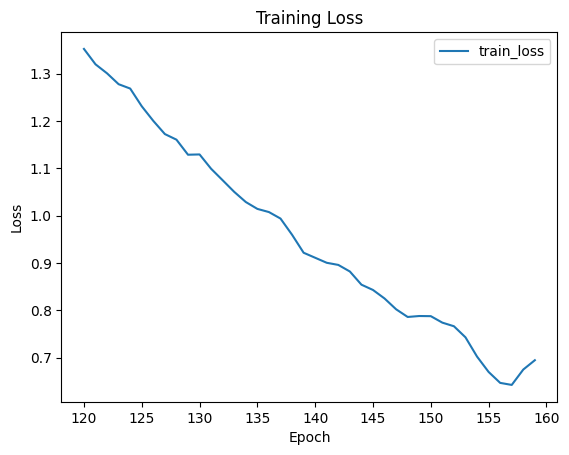

In [ ]:
fig,ax=plt.subplots()
ax.plot([i for i in range(120,160)],train_loss,label="train_loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training Loss")
ax.legend()
plt.show()

In [ ]:
target[0]

tensor([499., 777., 769.,  13., 133.,  27.,  18., 643.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

In [ ]:
lengths

tensor([10, 10, 13, 10, 10,  8, 12, 11, 10, 18, 11, 11, 12,  9, 10, 12, 11, 10,
        10, 11, 11, 20, 13, 12, 10, 12, 12, 11, 12, 11, 12, 13,  9, 11,  9,  9,
        14, 10, 11, 11, 10, 14, 12, 10, 12, 11,  9, 10, 11, 11,  9, 12, 15, 14,
        14, 15, 12, 10, 11, 21, 11, 11, 11, 10])

## 4 Generate predictions on test data [8 marks]

Display 5 sample test images containing different objects, along with your model’s generated captions and all the reference captions for each.

> Remember that everything **displayed** in the submitted notebook and .html file will be marked, so be sure to run all relevant cells.

In [14]:
def idx_to_word(idx):
  #convert idx to captions
  output=''
  try:
    for i in idx:
      output += full_vocab.get_word(int(i))+' '
  except:
    output += full_vocab.get_word(int(idx))+' '
  return output
def generate_test_data(number,idx_length=1):
  # generate data from dataloader for decoder testing 
  imgfeature_list=[]
  idx_list=[]
  ground_truth_list=[]
  name_list=[]
  for features,captions,lengths,name in full_loader:
    captions=captions.unsqueeze(dim=1)
    for i in range(number):
      img_feature=features[i]
      imgfeature_list.append(img_feature)
      ground_truth=captions[i]
      ground_truth_list.append(ground_truth)
      idx=ground_truth[0,0:idx_length] # initialise token sequence and generated sequence
      idx_list.append(idx)
      name_list.append(name[i])
      print(idx)
    break
    return imgfeature_list,idx_list,ground_truth_list,name_list
def generate_full_test_data(idx_length=1):
  # generate data from dataloader for full decoder testing 
  imgfeature_list=[]
  idx_list=[]
  ground_truth_list=[]
  name_list=[]
  for features,captions,lengths,name in full_loader:
    captions=captions.unsqueeze(dim=1)
    for i in range(len(lengths)):
      img_feature=features[i]
      imgfeature_list.append(img_feature)
      ground_truth=captions[i]
      ground_truth_list.append(ground_truth)
      idx=ground_truth[0,0:idx_length] # initialise token sequence and generated sequence
      idx_list.append(idx)
      name_list.append(name[i])
  return imgfeature_list,idx_list,ground_truth_list,name_list

In [ ]:
# generate test data
imgfeature_list,idx_list,ground_truth_list,name_list=generate_test_data(5)

tensor([3.])
tensor([10.])
tensor([18.])
tensor([18.])
tensor([18.])


In [ ]:
torch.save(imgfeature_list,"/content/drive/MyDrive/DeepLearing/cw2/sample_data/imgfeature_list.pt")
torch.save(idx_list,"/content/drive/MyDrive/DeepLearing/cw2/sample_data/idx_list.pt")
torch.save(ground_truth_list,"/content/drive/MyDrive/DeepLearing/cw2/sample_data/ground_truth_list.pt")
torch.save(name_list,"/content/drive/MyDrive/DeepLearing/cw2/sample_data/name_list.pt")

In [16]:

imgfeature_list=torch.load("/content/drive/MyDrive/DeepLearing/cw2/sample_data/imgfeature_list.pt")
idx_list=torch.load("/content/drive/MyDrive/DeepLearing/cw2/sample_data/idx_list.pt")
ground_truth_list=torch.load("/content/drive/MyDrive/DeepLearing/cw2/sample_data/ground_truth_list.pt")
name_list=torch.load("/content/drive/MyDrive/DeepLearing/cw2/sample_data/name_list.pt")

In [ ]:
ground_truth_list[0][0]

tensor([3., 4., 5., 6., 7., 8., 9., 7., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
name_list

['000000057429.jpg',
 '000000410627.jpg',
 '000000554037.jpg',
 '000000143370.jpg',
 '000000540860.jpg']

In [20]:
IMAGE_DIR = "/content/drive/MyDrive/DeepLearing/COMP5625M_data_assessment_2/coco/images/"
def show_image(file_name):
  # show a image with file_name
  file_path=IMAGE_DIR+file_name
  image = Image.open(file_path).convert("RGB")
  image.show() 

In [22]:
# restore model parameters and losses
state_epoch=157 # The number of state_dict we want to read
root="/content/drive/MyDrive/DeepLearing/cw2/decoder_checkpoint/model_e"
url=root+str(state_epoch)+".pt"
decoder.load_state_dict(torch.load(url))
decoder.eval() # set eval mode so that dropout is omitted by the module

# print("Ground truth: ",idx_to_word(ground_truth_list[0][0]))

def decoder_predict(img_feature,idx,ground_truth,img_filename,print_result=True):
  # prior text length
  idx_length=1
  #if sentence end, mark=1
  flag=0
  gen_length = 46    # length of generated text
  if print_result:
    # show image
    show_image(img_filename)
    # show captions
    print("Ground truth: ",idx_to_word(ground_truth))
  # set prior text
  output=idx_to_word(idx)
  if print_result:
    # show initial text
    print("Initial text: ",output)
  inputs = torch.unsqueeze(idx,0).long() # add batch dimension of size 1: 1 x len(idx) x input_size
  # inputs = torch.unsqueeze(inputs,0).long()
  # sample from the network.
  zero_hidden = True    # initialise hidden state to zero for the first time through    
  with torch.no_grad():    # turn off gradient calculations for the evaluation
    for i in range(gen_length):
      outputs = decoder(img_feature,inputs,[idx_length,],zero_hidden)
      _, predicted =torch.max(outputs[0],dim=1)
      token = predicted[-1].item()    # extract final predicted token as input for next timestep
      if flag==0:
        output = output + idx_to_word(token)       # decode token and append to output
      else:
        output = output + '<pad>'
      output+=' '
      if token==2:
        flag=1
      idx_length+=1
      # inputs = torch.unsqueeze(predicted,0).long()    # input sequence consisting of a single time step
      idx=torch.tensor(token)
      idx=torch.unsqueeze(idx,0)
      inputs=torch.cat((inputs[0,:],idx),0).long()
      inputs=torch.unsqueeze(inputs,0)
      zero_hidden = False               # pass on the hidden state in future iterations
  if print_result:          
    print("Generate captions: ",output)
  return idx_to_word(ground_truth),output
   

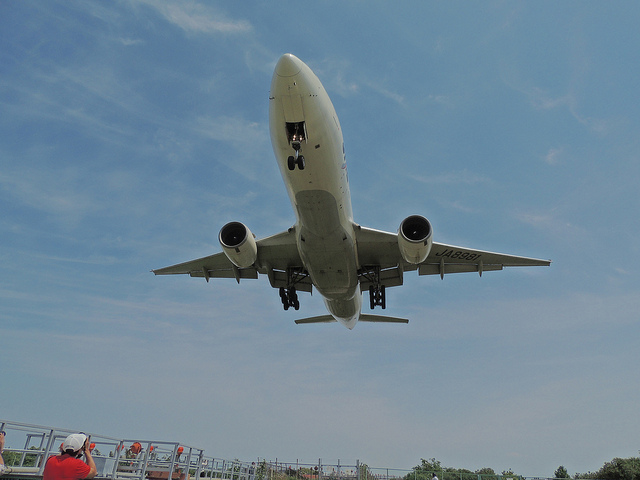

Ground truth:  an airplane with its landing wheels out landing <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
Initial text:  an 
Generate captions:  an airplane  flying  <unk>  <end>  <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


In [24]:
i=0
ground_truth,feature_captions=decoder_predict(imgfeature_list[i],idx_list[i],ground_truth_list[i][0],name_list[i])

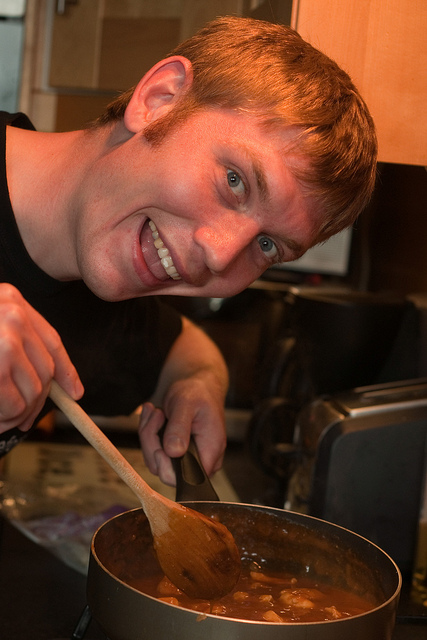

Ground truth:  the young man is <unk> his pot of food with a wooden spoon <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
Initial text:  the 
Generate captions:  the young  girl  is  is  <end>  <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


In [25]:
i=1
ground_truth,feature_captions=decoder_predict(imgfeature_list[i],idx_list[i],ground_truth_list[i][0],name_list[i])

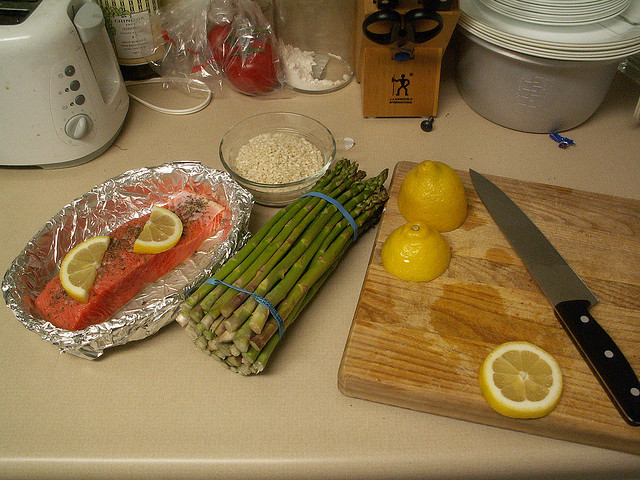

Ground truth:  a counter with vegetables knife and cutting board on it <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
Initial text:  a 
Generate captions:  a counter  with  vegetables  and  a  tray  on  the  counter  <end>  <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


In [26]:
i=2
ground_truth,feature_captions=decoder_predict(imgfeature_list[i],idx_list[i],ground_truth_list[i][0],name_list[i])

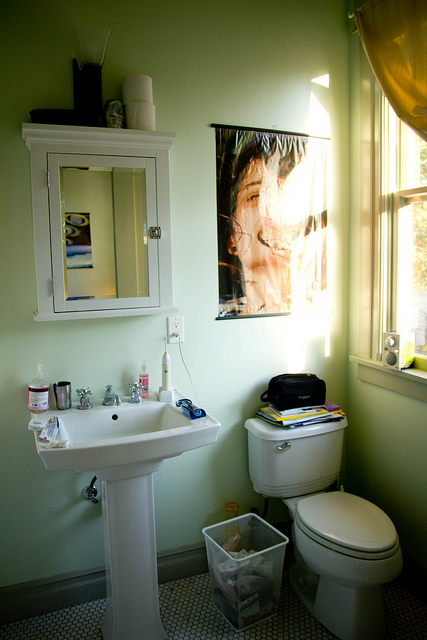

Ground truth:  a bathroom with a <unk> of an <unk> face above the <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
Initial text:  a 
Generate captions:  a bathroom  bathroom  with  the  <unk>  <end>  <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


In [27]:
i=3
ground_truth,feature_captions=decoder_predict(imgfeature_list[i],idx_list[i],ground_truth_list[i][0],name_list[i])

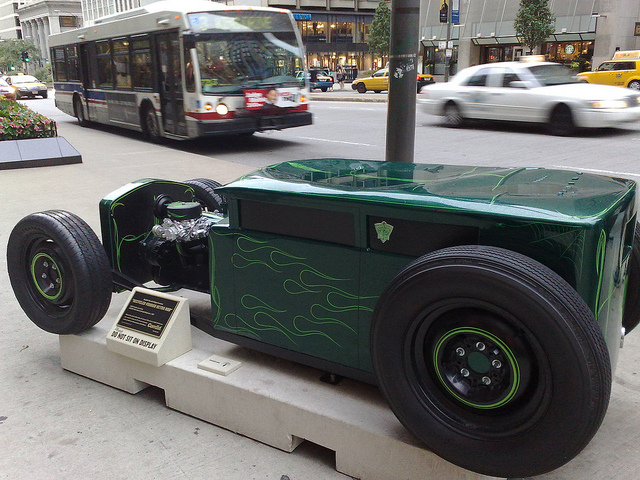

Ground truth:  a green car on display next to a busy street <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
Initial text:  a 
Generate captions:  a green  car  next  to  <end>  <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


In [28]:
i=4
ground_truth,feature_captions=decoder_predict(imgfeature_list[i],idx_list[i],ground_truth_list[i][0],name_list[i])

## 5 Caption evaluation using BLEU score [10 marks]

There are different methods for measuring the performance of image to text models. We will evaluate our model by measuring the text similarity between the generated caption and the reference captions, using two commonly used methods. Ther first method is known as *Bilingual Evaluation Understudy (BLEU)*.

> 5.1 Average BLEU score on all data (5 marks)

> 5.2 Examplaire high and low score BLEU score samples (5 marks, at least two)

####  5.1 Average BLEU score on all data (5 marks)


One common way of comparing a generated text to a reference text is using BLEU. This article gives a good intuition to how the BLEU score is computed: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/, and you may find an implementation online to use. One option is the NLTK implementation `nltk.translate.bleu_score` here: https://www.nltk.org/api/nltk.translate.bleu_score.html


> **Tip:** BLEU scores can be weighted by ith-gram. Check that your scores make sense; and feel free to use a weighting that best matches the data. We will not be looking for specific score ranges; rather we will check that the scores are reasonable and meaningful given the captions.

Write the code to evaluate the trained model on the complete test set and calculate the BLEU score using the predictions, compared against all five references captions. 

Display a histogram of the distribution of scores over the test set.

In [ ]:
# TO COMPLETE
from nltk.translate.bleu_score import sentence_bleu
stats = pd.DataFrame(columns=['ref','preds','bleu','cos_sim'])#dict()
# --> Your code here!
all_imgfeature_list,all_idx_list,all_ground_truth_list,all_name_list=generate_full_test_data()
for i in range(len(name_list)):
  #generate prediction for every sample (took forever)
  ground_truth,feature_captions=decoder_predict(all_imgfeature_list[i],all_idx_list[i],all_ground_truth_list[i][0],all_name_list[i],print_result=False)
  #write dataframe
  stats.loc[i]=[ground_truth,feature_captions,0,0]

In [ ]:
for i in range(len(name_list)):
  reference=[stats.loc[i]['ref'].split()]
  candidate=stats.loc[i]['preds'].split()
  bleu_score = sentence_bleu(reference, candidate)
  stats.loc[i,'bleu']=bleu_score
  # print(reference)
  # print(bleu_score)
  # break

Average BLEU score: 0.8189097040537947


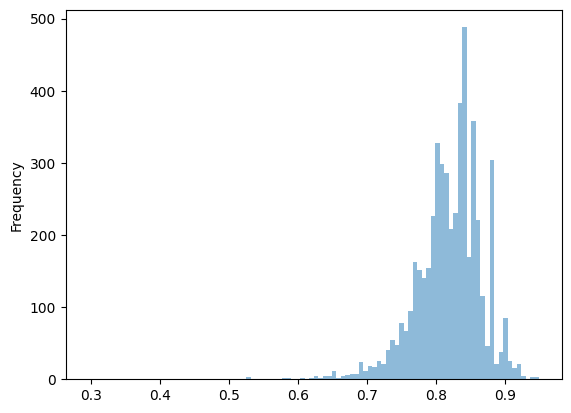

In [80]:
print("Average BLEU score:", stats['bleu'].mean())
ax = stats['bleu'].plot.hist(bins=100, alpha=0.5)

In [82]:
stats['bleu'].max()

0.9499061377633666

#### 5.2 Examplaire high and low score BLEU score samples (5 marks)

Find one sample with high BLEU score and one with a low score, and display the model's predicted sentences, the BLEU scores, and the 5 reference captions.

In [90]:
# TO COMPLETE
stats.sort_values(by=['bleu']).head(5)

ref  \
3959  a table with a person holding a sandwich in ha...   
3664  the scene is set with a big sky and high grass...   
3954  a skateboarder heads down a decorated ramp aga...   
3302  a large horse looking down at a young girl as ...   
3251  a horse is pulling a green wagon that has a ma...   

                                                  preds      bleu  cos_sim  
3959  a plate  with  a  sandwich  on  it  and  anoth...  0.295933        0  
3664  the cows  holding  a  grass  <unk>  <unk>  and...  0.411815        0  
3954  a skateboarder  doing  a  <unk>  that  of  sno...  0.417409        0  
3302  a large  horse  as  an  head  and  an  horse  ...  0.428263        0  
3251  a horse  is  horses  in  a  horse  <end>  <pad...  0.473555        0

In [91]:
stats.sort_values(by=['bleu'],ascending=False).head(5)

ref  \
1217  a black computer keyboard sitting on a table <...   
2680  a truck that is sitting in the grass <end> <pa...   
4590  a toaster that is sitting on a sidewalk <end> ...   
4161  a person <unk> with a tennis racket <end> <pad...   
1198  a desktop computer sitting on top of a wooden ...   

                                                  preds      bleu  cos_sim  
1217  a black  keyboard  sitting  on  a  table  <end...  0.949906        0  
2680  a truck  that  is  sitting  on  the  grass  <e...  0.944060        0  
4590  a toaster  that  sitting  on  a  sidewalk  <en...  0.944060        0  
4161  a man  with  a  tennis  racket  <end>  <pad> <...  0.939287        0  
1198  a laptop  sitting  on  top  of  a  wooden  des...  0.939287        0

## 6 Caption evaluation using cosine similarity [12 marks]

> 6.1 Cosine similarity (6 marks)

> 6.2 Cosine similarity examples (6 marks)

####  6.1 Cosine similarity (6 marks)

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions: 

* Find the embedding vector of each word in the caption 
* Compute the average vector for each caption 
* Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Compute the average of these scores 

Calculate the cosine similarity using the model's predictions over the whole test set. 

Display a histogram of the distribution of scores over the test set.

In [83]:
# TO COMPLETE
from scipy import spatial
Embed=decoder.embed

In [107]:
def gen_vector(str):
  vector=torch.zeros(256)
  word_list=str.split()
  for word in word_list:
    idx=full_vocab.__call__(word)
    vector+=Embed(torch.tensor(idx)).detach().numpy()
  return vector/len(word_list)
def cos_sim(str1,str2):
  vector1=gen_vector(str1)
  vector2=gen_vector(str2)
  result = 1 - spatial.distance.cosine(vector1, vector2)
  return result
cos_sim("a man","a person")

0.9734519124031067

In [108]:
for i in range(len(name_list)):
  reference=stats.loc[i]['ref']
  candidate=stats.loc[i]['preds']
  cosin_score = cos_sim(reference, candidate)
  stats.loc[i,'cos_sim']=cosin_score

In [114]:
torch.save(stats,"/content/drive/MyDrive/DeepLearing/cw2/sample_data/DataFrame_score.pt")

In [116]:
torch.save(all_imgfeature_list,"/content/drive/MyDrive/DeepLearing/cw2/sample_data/all_imgfeature_list.pt")
torch.save(all_idx_list,"/content/drive/MyDrive/DeepLearing/cw2/sample_data/all_idx_list.pt")
torch.save(all_ground_truth_list,"/content/drive/MyDrive/DeepLearing/cw2/sample_data/all_ground_truth_list.pt")
torch.save(all_name_list,"/content/drive/MyDrive/DeepLearing/cw2/sample_data/all_name_list.pt")
torch.save(stats,"/content/drive/MyDrive/DeepLearing/cw2/sample_data/DataFrame_score.pt")

In [115]:
all_imgfeature_list=torch.load("/content/drive/MyDrive/DeepLearing/cw2/sample_data/all_imgfeature_list.pt")
all_idx_list=torch.load("/content/drive/MyDrive/DeepLearing/cw2/sample_data/all_idx_list.pt")
all_ground_truth_list=torch.load("/content/drive/MyDrive/DeepLearing/cw2/sample_data/all_ground_truth_list.pt")
all_name_list=torch.load("/content/drive/MyDrive/DeepLearing/cw2/sample_data/all_name_list.pt")
stats=torch.load("/content/drive/MyDrive/DeepLearing/cw2/sample_data/DataFrame_score.pt")

In [97]:
torch.zeros(256).shape

torch.Size([256])

#### 6.2 Cosine similarity examples (6 marks)

Find one sample with high cosine similarity score and one with a low score, and display the model's predicted sentences, the cosine similarity scores, and the 5 reference captions.

In [118]:
stats.sort_values(by=['cos_sim'],ascending=True).head(5)

ref  \
3176  there are many woman on the field playing fris...   
1399  man and woman on an ice covered bridge <end> <...   
2417  people walking in the city beside buildings an...   
809   animals walk around a grassy area together <en...   
3008  two baby elephants walk next to water and othe...   

                                                  preds      bleu   cos_sim  
3176  there are  <unk>  a  field  <end>  <pad> <pad>...  0.822914 -0.570370  
1399  man person  on  a  snow  <end>  <pad> <pad> <p...  0.834426 -0.541601  
2417  people walking  down  a  city  <end>  <pad> <p...  0.800888 -0.469734  
809   animals zebra  next  to  the  other  <end>  <p...  0.851291 -0.447153  
3008  two elephants  standing  in  a  grassy  field ...  0.790402 -0.439714

In [119]:
stats.sort_values(by=['cos_sim'],ascending=False).head(5)

ref  \
1217  a black computer keyboard sitting on a table <...   
2899  two dogs sit in an outdoor dirt patch <end> <p...   
3864  a table is set with a bowl of fruit <end> <pad...   
4833  a flower vase is sitting on a <unk> stand <end...   
240   a bunch of animals in a grassy area <end> <pad...   

                                                  preds      bleu   cos_sim  
1217  a black  keyboard  sitting  on  a  table  <end...  0.949906  0.999929  
2899  two dogs  in  an  dirt  <end>  <pad> <pad> <pa...  0.860249  0.999884  
3864  a table  is  with  a  bowl  of  soup  <end>  <...  0.887313  0.999828  
4833  a vase  is  sitting  on  a  <unk>  <end>  <pad...  0.905099  0.999771  
240   a bunch  of  in  a  horse  <end>  <pad> <pad> ...  0.871366  0.999737

## 7 Comparing BLEU and Cosine similarity [16 marks]

> 7.1 Test set distribution of scores (6 marks)

> 7.2 Analysis of individual examples (10 marks)

#### 7.1 Test set distribution of scores (6 marks)

Compare the model’s performance on the test set evaluated using BLEU and cosine similarity and discuss some weaknesses and strengths of each method (explain in words, in a text box below). 

Please note, to compare the average test scores, you need to rescale the Cosine similarity scores [-1 to 1] to match the range of BLEU method [0.0 - 1.0].

In [138]:
((stats['cos_sim']+1)/2).mean()

0.9133187895840346

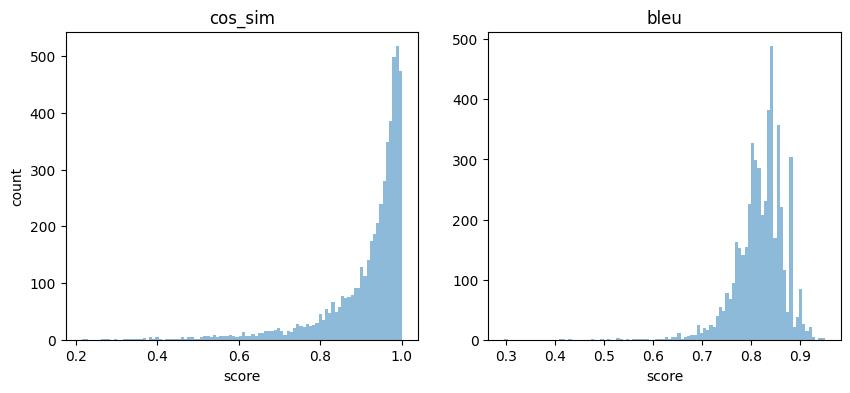

In [137]:
# TO COMPLETE
# print("Average BLEU score:", stats['cos_sim'].mean())
fig, axs = plt.subplots(1,2,figsize=(10, 4))
ax=axs[0].hist(((stats['cos_sim']+1)/2),bins=100, alpha=0.5)
_=axs[0].set_title("cos_sim")
_=axs[0].set_xlabel("score")
_=axs[0].set_ylabel("count")
ax=axs[1].hist(stats['bleu'],bins=100, alpha=0.5)
_=axs[1].set_title("bleu")
_=axs[1].set_xlabel("score")
_=axs[0].set_ylabel("count")

Comment: When using the Bleu score, the mean is 0.818, the median is around 8.5. Whereas in cosine similarity, mean and median values are around 0.94.
This shows that, in general, although some words differ from the original, they tend to have similar vertex when added up.

 #### 7.2 Analysis of individual examples (10 marks)
 
Find and display one example where both methods give similar scores and another example where they do not and discuss. Include both scores, predicted captions, and reference captions.

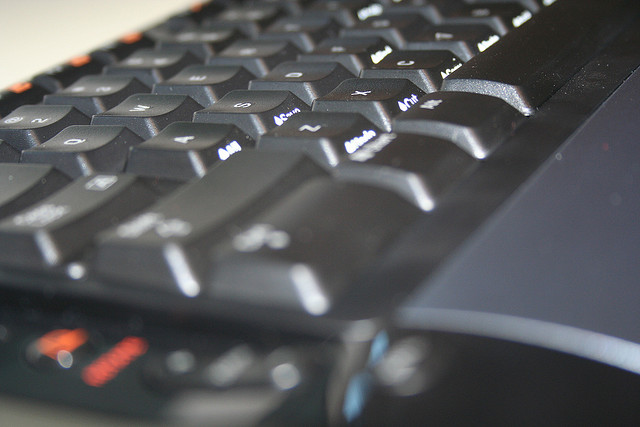

In [141]:
# TO COMPLETE
#similar
idx_sim=1217
show_image(all_name_list[idx_sim])

In [147]:
print("reference captions: ",stats.iloc[idx_sim].values[0])
print("predicted captions: ",stats.iloc[idx_sim].values[1])
print("bleu score: ",stats.iloc[idx_sim].values[2])
print("cosine score:",stats.iloc[idx_sim].values[3])

reference captions:  a black computer keyboard sitting on a table <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
predicted captions:  a black  keyboard  sitting  on  a  table  <end>  <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
bleu score:  0.9499061377633666
cosine score: 0.9999291300773621


Comment: In the Bleu score, 7 out of 8 words are correct; 45 out of 46 predicted vocabularies are correct, so we have a high score here.
The main object in this image is a keyboard, and my prediction failed to predict the word before, which is "computer". In reality, and the word embedding learned by my network, "computer keyboard" is the same as "keyboard". Hence, the final vector is almost the same as the reference captions, and we also got a high score in the cosine similarity.


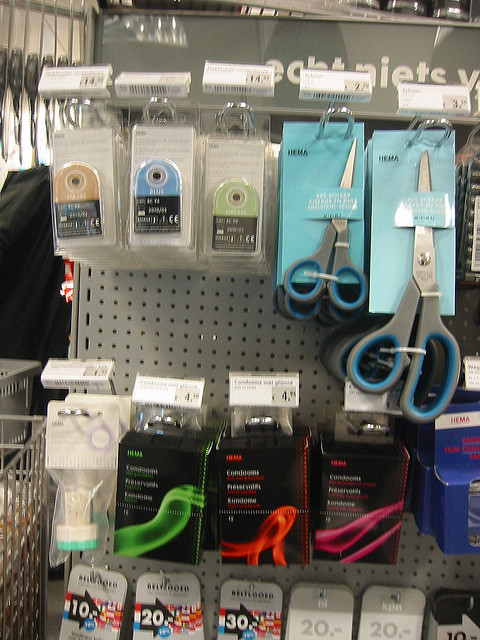

In [154]:
#differ
idx_diff=5066
show_image(all_name_list[idx_diff])

In [155]:
print("reference captions: ",stats.iloc[idx_diff].values[0])
print("predicted captions: ",stats.iloc[idx_diff].values[1])
print("bleu score: ",stats.iloc[idx_diff].values[2])
print("cosine score:",stats.iloc[idx_diff].values[3])

reference captions:  some store items hanging on a display wall <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
predicted captions:  some store  items  on  <end>  <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
bleu score:  0.8610401761271786
cosine score: 0.18099269270896912


Comment: In the Bleu score, 4 out of 8 words are correct; 42 out of 46 predicted vocabularies are correct, so we have a high score here.
The main object in this image is a display wall, and my prediction failed to predict that word, and the final vector is about 90 degrees away from the reference captions and we got a low score in the cosine similarity.
